<a href="https://colab.research.google.com/github/q759729997/qyt_python_collections/blob/master/ucas/%E8%AE%A1%E7%AE%97%E6%9C%BA%E8%A7%86%E8%A7%89/MidProject/mid_project_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

数据分析

### Reqirements
- keras >= 2.2.0 or tensorflow >= 1.13
- segmenation-models==1.0.*
- albumentations==0.3.0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Install required libs

### please update Albumentations to version>=0.3.0 for `Lambda` transform support
!pip install -U albumentations
!pip install -U --pre segmentation-models

     |████████████████████████████████| 122kB 13.4MB/s 
     |████████████████████████████████| 952kB 18.0MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp36-none-any.whl size=65164 sha256=5670126ccc945caa2d5123044f59d8a4e4965636569e06a972e1ce0793edb50f
  Stored in directory: /root/.cache/pip/wheels/c7/f4/89/56d1bee5c421c36c1a951eeb4adcc32fbb82f5344c086efa14
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


# Loading dataset

For this example we will use **煤矸石** dataset. It is a set of:
 - **train** images + segmentation masks
 - **validation** images + segmentation masks
 - **test** images + segmentation masks
 
All images have 480 pixels height and 852 pixels width.

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [ ]:
DATA_DIR = '/content/drive/My Drive/data/cv/MidProject'

if not os.path.exists(DATA_DIR):
    print('Loading data...')
    print('Done!')

In [ ]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

In [ ]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

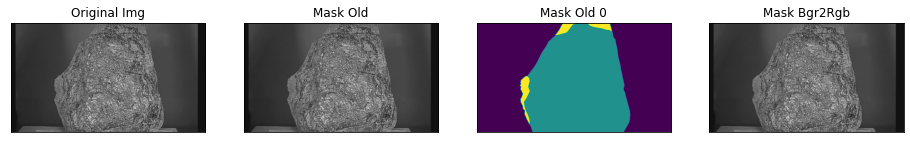

In [ ]:
# train图片查看
original_img = cv2.imread(os.path.join(x_train_dir, '1.jpg'))
mask_old = cv2.imread(os.path.join(x_train_dir, '1.jpg'))
mask_old_0 = cv2.imread(os.path.join(y_train_dir, '1.png'), 0)
mask_BGR2RGB = cv2.cvtColor(mask_old, cv2.COLOR_BGR2RGB)
visualize(
    original_img=original_img,
    mask_old=mask_old,
    mask_old_0=mask_old_0,
    mask_BGR2RGB=mask_BGR2RGB,
)

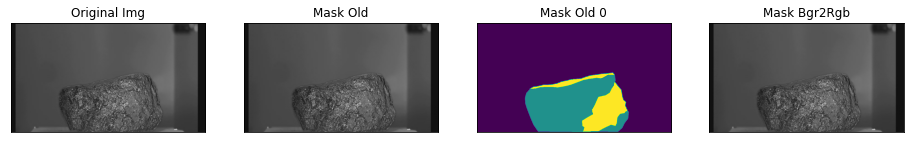

In [ ]:
# val图片查看
original_img = cv2.imread(os.path.join(x_valid_dir, '181.jpg'))
mask_old = cv2.imread(os.path.join(x_valid_dir, '181.jpg'))
mask_old_0 = cv2.imread(os.path.join(y_valid_dir, '181.png'), 0)
mask_BGR2RGB = cv2.cvtColor(mask_old, cv2.COLOR_BGR2RGB)
visualize(
    original_img=original_img,
    mask_old=mask_old,
    mask_old_0=mask_old_0,
    mask_BGR2RGB=mask_BGR2RGB,
)

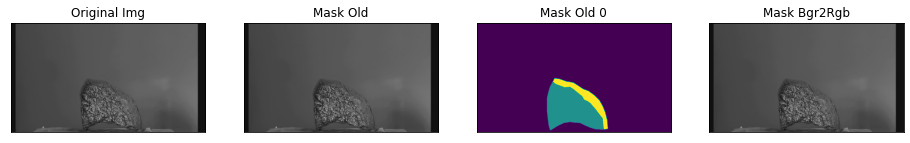

In [ ]:
# test图片查看
original_img = cv2.imread(os.path.join(x_test_dir, '201.jpg'))
mask_old = cv2.imread(os.path.join(x_test_dir, '201.jpg'))
mask_old_0 = cv2.imread(os.path.join(y_test_dir, '201.png'), 0)
mask_BGR2RGB = cv2.cvtColor(mask_old, cv2.COLOR_BGR2RGB)
visualize(
    original_img=original_img,
    mask_old=mask_old,
    mask_old_0=mask_old_0,
    mask_BGR2RGB=mask_BGR2RGB,
)

In [ ]:
from tqdm import tqdm

In [ ]:
# 查看mask的序号
mask_nums = set()
image_files = os.listdir(y_train_dir)
for image_file in tqdm(image_files):
  mask_image = cv2.imread(os.path.join(y_train_dir, image_file), 0)
  for row_nums in list(mask_image):
    for cell_num in row_nums:
      mask_nums.add(cell_num)
mask_nums = list(mask_nums)
mask_nums.sort()
print(mask_nums)
# 100%|██████████| 180/180 [01:19<00:00,  2.27it/s][0, 38, 75]

100%|██████████| 180/180 [02:03<00:00,  1.46it/s]

[0, 38, 75]


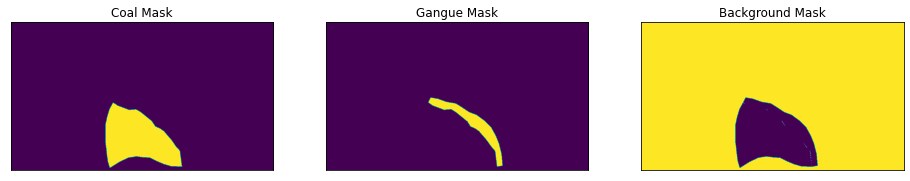

In [ ]:
masks = [(mask_old_0 == v) for v in [38, 75]]
# print(masks)
mask = np.stack(masks, axis=-1).astype('float')
# print(mask)
if mask.shape[-1] != 1:
  background = 1 - mask.sum(axis=-1, keepdims=True)
  mask = np.concatenate((mask, background), axis=-1)
# print(len(image), len(image[0]))
# print(len(mask), len(mask[0]))
visualize(
    coal_mask=mask[..., 0].squeeze(),
    gangue_mask=mask[..., 1].squeeze(),
    background_mask=mask[..., 2].squeeze(),
)

# Dataloader and utility functions 

In [ ]:
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['coal', 'gangue']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id).replace('.jpg', '.png') for image_id in self.ids]
        print('ids len:{}, example:{}'.format(len(self.ids), self.ids[:3]))
        print('images_fps len:{}, example:{}'.format(len(self.images_fps), self.images_fps[:3]))
        print('masks_fps len:{}, example:{}'.format(len(self.masks_fps), self.masks_fps[:3]))
        
        # convert str names to class values on masks
        self.class_values = [38, 75]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        # mask = cv2.imread(self.masks_fps[i])
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)   

  0%|          | 0/180 [00:00<?, ?it/s]

查看训练集
ids len:180, example:['179.jpg', '175.jpg', '173.jpg']
images_fps len:180, example:['/content/drive/My Drive/data/cv/MidProject/train/179.jpg', '/content/drive/My Drive/data/cv/MidProject/train/175.jpg', '/content/drive/My Drive/data/cv/MidProject/train/173.jpg']
masks_fps len:180, example:['/content/drive/My Drive/data/cv/MidProject/trainannot/179.png', '/content/drive/My Drive/data/cv/MidProject/trainannot/175.png', '/content/drive/My Drive/data/cv/MidProject/trainannot/173.png']
第一条数据形状
480 852
480 852
分析统计数据形状


100%|██████████| 180/180 [01:45<00:00,  1.71it/s]


image_shapes:[(480, 854), (480, 852)]
mask_shapes:[(480, 854), (480, 852)]


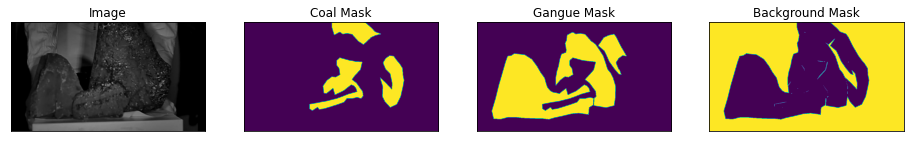

In [ ]:
# Lets look at train data we have
print('查看训练集')
dataset = Dataset(x_train_dir, y_train_dir, classes=['coal', 'gangue'])

image, mask = dataset[1] # get some sample
print('第一条数据形状')
print(len(image), len(image[0]))
print(len(mask), len(mask[0]))
print('分析统计数据形状')
image_shapes = set()
mask_shapes = set()
for i in tqdm(range(len(dataset))):
  image, mask = dataset[i]
  image_shapes.add((len(image), len(image[0])))
  mask_shapes.add((len(mask), len(mask[0])))
print('image_shapes:{}'.format(list(image_shapes)))
print('mask_shapes:{}'.format(list(mask_shapes)))
visualize(
    image=image, 
    coal_mask=mask[..., 0].squeeze(),
    gangue_mask=mask[..., 1].squeeze(),
    background_mask=mask[..., 2].squeeze(),
)

  0%|          | 0/20 [00:00<?, ?it/s]

查看开发集
ids len:20, example:['197.jpg', '193.jpg', '191.jpg']
images_fps len:20, example:['/content/drive/My Drive/data/cv/MidProject/val/197.jpg', '/content/drive/My Drive/data/cv/MidProject/val/193.jpg', '/content/drive/My Drive/data/cv/MidProject/val/191.jpg']
masks_fps len:20, example:['/content/drive/My Drive/data/cv/MidProject/valannot/197.png', '/content/drive/My Drive/data/cv/MidProject/valannot/193.png', '/content/drive/My Drive/data/cv/MidProject/valannot/191.png']
第一条数据形状
480 852
480 852
分析统计数据形状


100%|██████████| 20/20 [00:20<00:00,  1.03s/it]


image_shapes:[(480, 854), (480, 852)]
mask_shapes:[(480, 854), (480, 852)]


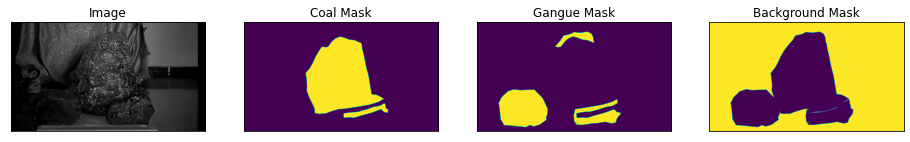

In [ ]:
# Lets look at valid data we have
print('查看开发集')
dataset = Dataset(x_valid_dir, y_valid_dir, classes=['coal', 'gangue'])

image, mask = dataset[1] # get some sample
print('第一条数据形状')
print(len(image), len(image[0]))
print(len(mask), len(mask[0]))
print('分析统计数据形状')
image_shapes = set()
mask_shapes = set()
for i in tqdm(range(len(dataset))):
  image, mask = dataset[i]
  image_shapes.add((len(image), len(image[0])))
  mask_shapes.add((len(mask), len(mask[0])))
print('image_shapes:{}'.format(list(image_shapes)))
print('mask_shapes:{}'.format(list(mask_shapes)))
visualize(
    image=image, 
    coal_mask=mask[..., 0].squeeze(),
    gangue_mask=mask[..., 1].squeeze(),
    background_mask=mask[..., 2].squeeze(),
)

  0%|          | 0/36 [00:00<?, ?it/s]

查看测试集
ids len:36, example:['209.jpg', '208.jpg', '212.jpg']
images_fps len:36, example:['/content/drive/My Drive/data/cv/MidProject/test/209.jpg', '/content/drive/My Drive/data/cv/MidProject/test/208.jpg', '/content/drive/My Drive/data/cv/MidProject/test/212.jpg']
masks_fps len:36, example:['/content/drive/My Drive/data/cv/MidProject/testannot/209.png', '/content/drive/My Drive/data/cv/MidProject/testannot/208.png', '/content/drive/My Drive/data/cv/MidProject/testannot/212.png']
第一条数据形状
480 852
480 852
分析统计数据形状


100%|██████████| 36/36 [00:43<00:00,  1.22s/it]


image_shapes:[(480, 852)]
mask_shapes:[(480, 852)]


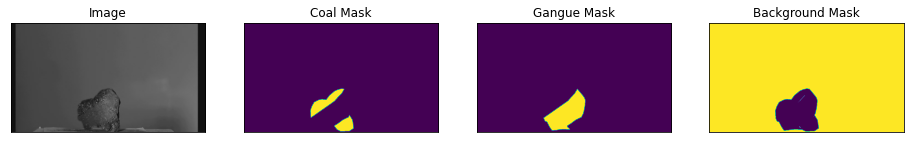

In [ ]:
# Lets look at test data we have
print('查看测试集')
dataset = Dataset(x_test_dir, y_test_dir, classes=['coal', 'gangue'])

image, mask = dataset[1] # get some sample
print('第一条数据形状')
print(len(image), len(image[0]))
print(len(mask), len(mask[0]))
print('分析统计数据形状')
image_shapes = set()
mask_shapes = set()
for i in tqdm(range(len(dataset))):
  image, mask = dataset[i]
  image_shapes.add((len(image), len(image[0])))
  mask_shapes.add((len(mask), len(mask[0])))
print('image_shapes:{}'.format(list(image_shapes)))
print('mask_shapes:{}'.format(list(mask_shapes)))
visualize(
    image=image, 
    coal_mask=mask[..., 0].squeeze(),
    gangue_mask=mask[..., 1].squeeze(),
    background_mask=mask[..., 2].squeeze(),
)